#### Summary:
Use this notebook to read in all results from the individual sample processing pipeline and combine donor data into one Seurat object. Then remove doublets and low quality barcodes and cluster. Normally we'd cluster the data and visualize the outputs at each step, but to streamline this notebook I've only kept plots at the end.

Required inputs:
- Text file of 50k windows to use to combine ATAC data (format: chr#-start-end), we have generated this previously by merging a subset of samples and then running FindVariableFeatures()
- Text files of all sample barcodes identified as doublets by AMULET or Scrublet (2 separate files, each line is different doublet barcode)

In [1]:
#always run this first!!
#essential reticulate functions that allow us to use python packages in R
#you'll need a conda env with 'leidenalg' and 'pandas' installed to do this
#then route reticulate to the python installed in that conda env with the below functions
Sys.setenv(RETICULATE_PYTHON="/path/to/.conda/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/path/to/.conda/envs/reticulate/bin/python")
reticulate::use_condaenv("/path/to/.conda/envs/reticulate/bin/python")
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(leidenalg)

In [2]:
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Hsapiens.v86))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
suppressMessages(library(harmony))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
suppressMessages(library(future))

In [ ]:
suppressMessages(library(textclean))
suppressMessages(library(ggplot2))
suppressMessages(library(MASS))
suppressMessages(library(stringr))
suppressMessages(library(mclust))

In [ ]:
samples <- c('R207', 'R217', 'R218', 'R221', 'R223',
             'R226', 'R228', 'R234', 'R237', 'R238',
             'R246', 'R247', 'R275', 'R284', 'R290', 
             'R292', 'R316', 'R317', 'R319', 'R325',
             'R326', 'R327', 'R332', 'R353', 'R354',
             'R362', 'R363', 'R364')

In [ ]:
#input files paths -- CHANGE THESE
cellranger_outs_dir <- '/path/to/cellranger/outputs'
pipeline_outdir <- '/path/to/processing/pipeline/outputs'
outdir <- '/path/to/save/outputs'

hvw_fp <- '/path/to/50k/windows/fp/ex/4samples_VariableFeatures_HVWs.txt'
amulet_doublet_fp <- '/path/to/amulet/doublets/list'
scrublet_doublet_fp <- '/path/to/scrublet/doublets/list'

# Read in individually processed data and combine

In [4]:
#make the merged fragment file (update all filepaths and variables!)
system(sprintf('for SAMPLE in %s; do zcat %s/$SAMPLE/outs/atac_fragments.tsv.gz | awk -v SAMPLE=$SAMPLE \'BEGIN{FS=OFS="\t"} {print $1,$2,$3,SAMPLE"_"$4,$5}\'; done | sort -k1,1 -k2,2n -S 64G | bgzip -c -@ 16 > %s/merged.atac_fragments.tsv.gz', paste0(samples, collapse=' '),cellranger_outs_dir, outdir))
system('tabix -p bed /nfs/lab/hmummey/multiomic_islet/intermediates/211010_ATAC_HVW_tests/31samples_merged.atac_fragments.tsv.gz')
frag.file <- file.path(outdir,'3merged.atac_fragments.tsv.gz')

## Read in and merge RNA data

In [6]:
#read in the RDS files
#wipe out the ATAC and SCT componenets, just keep raw RNA
adatas <- list()
for (sample in samples){
    adata <- readRDS(file = sprintf("/nfs/lab/projects/multiomic_islet/outputs/multiome/indv_sample_processing/%s/final_filtered.rds",sample))
    adatas[[sample]] <- adata
    DefaultAssay(adatas[[sample]]) <- "RNA"
    adatas[[sample]][['ATAC']] <- NULL
    adatas[[sample]][['SCT']] <- NULL
}
adatas
#adatas[1]

$R207
An object of class Seurat 
36601 features across 9678 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: umap.rna, umap.atac, umap.wnn

$R217
An object of class Seurat 
36601 features across 10672 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: umap.rna, umap.atac, umap.wnn

$R218
An object of class Seurat 
36601 features across 5649 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: umap.rna, umap.atac, umap.wnn

$R221
An object of class Seurat 
36601 features across 7127 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductions calculated: umap.rna, umap.atac, umap.wnn

$R223
An object of class Seurat 
36601 features across 9469 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)
 3 dimensional reductio

In [8]:
# load in and merge RNA, making sure to add sample prefix to barcodes
adata <- merge(adatas[[samples[[1]]]], y=adatas[samples[2:length(samples)]], add.cell.ids=samples, project='multiomic')
adata$library <- sapply(strsplit(rownames(adata[[]]), '_'), '[[', 1)
adata
adatas <- NULL

An object of class Seurat 
36601 features across 251605 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

## Modified ATAC read in method

In [11]:
#read in ATAC data from the lfm matrices (sm workaround method for now)
# load in starting ATAC long format matrices to a list(CellRanger filtered for now)
atacs <- list()
for (sample in samples) {
    #print(sample)
    wd <- file.path(pipeline_outdir,sample)
    atacs[[sample]] <- read.table(file.path(wd, 'atac.long_fmt.filtered_barcode.mtx.gz'), sep='\t', header=FALSE, stringsAsFactors=FALSE)
    atacs[[sample]]$V1 <- as.factor(atacs[[sample]]$V1)
    atacs[[sample]]$V2 <- as.factor(paste0(sample, '_', atacs[[sample]]$V2))
}

In [13]:
#read in the HVWs set, we'll cut down all samples to be these windows
hvws2 <- scan(hvw_fp, what="", sep="\n")
print(head(hvws2))

#sort alphanumerically
hvws_fin2 <- sort(hvws2)
print(head(hvws_fin2))

[1] "chr17-2050000-2055000"    "chr2-218960000-218965000"
[3] "chr2-181680000-181685000" "chr16-705000-710000"     
[5] "chr7-101165000-101170000" "chr16-70700000-70705000" 
[1] "chr1-10050000-10055000"   "chr1-10055000-10060000"  
[3] "chr1-10070000-10075000"   "chr1-10075000-10080000"  
[5] "chr1-100790000-100795000" "chr1-10125000-10130000"  


In [15]:
#function which takes in a list of long format atac_fragment dfs with 
#sample names (df), an overall windows file (windows) and then makes these 
#into sparse matrices and merges them together

#modified to take in the hvws set and use those... will also check if 
#there's any missing windows and add those

merge_sparse_matrices_hvws <- function(dfs, windows){
    samples <- names(dfs)
    for (sample in samples){
        #get missing windows list for this sample
        print(paste(sample,Sys.time(),sep=': '))
        df <- dfs[[sample]]
        mis_windows <- windows[!windows %in% levels(df$V1)]
        
        #if there are missing_windows, add these in with filler data
        if (length(mis_windows) > 0){
            print('Adding missing windows')
            #create a new long format matrix (sm) with the missing windows added as 0 counts
            filler_bc <- as.character(df$V2[[1]])
            print(paste("Using filler BC:",filler_bc,sep=" "))
            new_rows <- cbind(as.data.frame(mis_windows),
                              as.data.frame(rep(filler_bc),length(mis_windows)),
                              as.data.frame(rep(0,length(mis_windows))))
            colnames(new_rows) <- c("V1","V2","V3")
            lfm <- rbind(df,new_rows)
        #if there aren't, set lfm to df
        } else {
            print('No windows were missing')
            lfm <- df
        }
        
        #cut down lfm to just be the hvws (windows)
        lfm_cut <- lfm[lfm$V1 %in% windows,]
        
        #set the levels of the lfm based on the desired bc order and reorder V1
        lfm_cut$V1 <- factor(lfm_cut$V1, levels=windows)
        lfm2 <- lfm_cut[order(lfm_cut$V1),]
        lfm2$V2 <- as.factor(lfm2$V2)
        
        if (sample == samples[1]){
            #if first sample, will make the overall sparse matrix 
            overall_sm <- with(lfm2,sparseMatrix(i=as.numeric(V1), j=as.numeric(V2), x=V3, dimnames=list(levels(V1), levels(V2))))
            print(dim(overall_sm))
            
        } else {
            #otherwise, convert into a sparse matrix and add to the overall one
            sm = with(lfm2,sparseMatrix(i=as.numeric(V1), j=as.numeric(V2), x=V3, dimnames=list(levels(V1), levels(V2))))
            print(dim(sm))
            overall_sm = cbind(overall_sm, sm) 
        }
    }
    return(overall_sm)
}

In [16]:
overall_sm2 <- merge_sparse_matrices_hvws(atacs,hvws_fin2)
dim(overall_sm2)
head(overall_sm2)

[1] "R207: 2021-10-13 23:45:15"
[1] "Adding missing windows"
[1] "Using filler BC: R207_AAACAGCCATTGTGTG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  9678
[1] "R217: 2021-10-13 23:46:08"
[1] "Adding missing windows"
[1] "Using filler BC: R217_AAAGCACCATTAAAGG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 10672
[1] "R218: 2021-10-13 23:46:56"
[1] "Adding missing windows"
[1] "Using filler BC: R218_AAACCGGCAGTACCGT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  5649
[1] "R221: 2021-10-13 23:47:30"
[1] "Adding missing windows"
[1] "Using filler BC: R221_AAAGCTTGTTAGTGAT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7127
[1] "R223: 2021-10-13 23:47:58"
[1] "Adding missing windows"
[1] "Using filler BC: R223_AAACGCGCAGCATTAT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  9469
[1] "R226: 2021-10-13 23:48:42"
[1] "Adding missing windows"
[1] "Using filler BC: R226_AAACGTACATATAACC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7842
[1] "R228: 2021-10-13 23:49:25"
[1] "Adding missing windows"
[1] "Using filler BC: R228_AAACGGATCATGTTTC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7475
[1] "R234: 2021-10-13 23:50:02"
[1] "Adding missing windows"
[1] "Using filler BC: R234_AAACCGAAGCCATCAG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  8505
[1] "R237: 2021-10-13 23:50:41"
[1] "Adding missing windows"
[1] "Using filler BC: R237_AAACCGCGTACAAAGA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7857
[1] "R238: 2021-10-13 23:51:32"
[1] "Adding missing windows"
[1] "Using filler BC: R238_AAACCAACAGCATGTC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7817
[1] "R246: 2021-10-13 23:52:08"
[1] "Adding missing windows"
[1] "Using filler BC: R246_AAGACAAGTATTCGTC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  2221
[1] "R247: 2021-10-13 23:52:25"
[1] "Adding missing windows"
[1] "Using filler BC: R247_AAAGCTTGTTAATGCG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7293
[1] "R275: 2021-10-13 23:53:09"
[1] "Adding missing windows"
[1] "Using filler BC: R275_AAACAGCCATTGTCAG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  6166
[1] "R277: 2021-10-13 23:53:37"
[1] "Adding missing windows"
[1] "Using filler BC: R277_AACATAGCACCTGGTG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  8029
[1] "R284: 2021-10-13 23:54:08"
[1] "Adding missing windows"
[1] "Using filler BC: R284_AACCTTAAGTGAACAG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7417
[1] "R290: 2021-10-13 23:54:57"
[1] "Adding missing windows"
[1] "Using filler BC: R290_AAATCCGGTCCTCCAA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  9380
[1] "R292: 2021-10-13 23:55:45"
[1] "Adding missing windows"
[1] "Using filler BC: R292_AAACATGCATGAATCT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  8103
[1] "R316: 2021-10-13 23:56:40"
[1] "Adding missing windows"
[1] "Using filler BC: R316_AAACAGCCATGAATAG-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 13171
[1] "R317: 2021-10-13 23:58:03"
[1] "Adding missing windows"
[1] "Using filler BC: R317_AAAGCCGCACAAACTT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 12520
[1] "R319: 2021-10-13 23:59:07"
[1] "Adding missing windows"
[1] "Using filler BC: R319_AAACGGATCCCTGGAA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 11438
[1] "R325: 2021-10-14 00:00:19"
[1] "Adding missing windows"
[1] "Using filler BC: R325_AATCCATCACTAAGCC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  2164
[1] "R326: 2021-10-14 00:00:38"
[1] "Adding missing windows"
[1] "Using filler BC: R326_AAATGCCTCTTGTCCA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 12198
[1] "R327: 2021-10-14 00:01:58"
[1] "Adding missing windows"
[1] "Using filler BC: R327_AAATGGCCAGTCTAGC-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  7811
[1] "R332: 2021-10-14 00:02:52"
[1] "Adding missing windows"
[1] "Using filler BC: R332_AAACCGAAGCTGCACA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 10156
[1] "R343: 2021-10-14 00:04:00"
[1] "Adding missing windows"
[1] "Using filler BC: R343_AACAGATAGCGGGCAA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  5808
[1] "R349: 2021-10-14 00:04:39"
[1] "Adding missing windows"
[1] "Using filler BC: R349_AACAGCAAGAGGCTAA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  6113
[1] "R353: 2021-10-14 00:05:19"
[1] "Adding missing windows"
[1] "Using filler BC: R353_AAAGCCCGTAATCGCA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  8720
[1] "R363: 2021-10-14 00:08:17"
[1] "Adding missing windows"
[1] "Using filler BC: R363_AAACCGCGTTAGGCTA-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000 10646
[1] "R364: 2021-10-14 00:09:27"
[1] "Adding missing windows"
[1] "Using filler BC: R364_AAATCCGGTACCAGGT-1"


Warning message in as.data.frame.vector(x, ..., nm = nm):
"'row.names' is not a character vector of length 1 -- omitting it. Will be an error!"


[1] 50000  5353


[1]  50000 251605

   [[ suppressing 34 column names 'R207_AAACAGCCAAACGGGC-1', 'R207_AAACAGCCACAAAGAC-1', 'R207_AAACAGCCAGCAAGTG-1' ... ]]



6 x 251605 sparse Matrix of class "dgCMatrix"
                                                                              
chr1-10050000-10055000   2 . . . . . . . . . . . 2 . . . . . . . . . . . . . .
chr1-10055000-10060000   2 2 . . . . . . 2 . . . 2 . . . . . . . . 2 . . . . .
chr1-10070000-10075000   . . . . . . . . . . . . . . . . 2 . . 2 . . . 4 . . .
chr1-10075000-10080000   . . . . . . . . . . . . . . . . 2 . . . . . . 4 . . .
chr1-100790000-100795000 1 . . . . . 1 . . . . . 2 . . . . . . 2 . . . . . . .
chr1-10125000-10130000   . . . . . . . 2 . 1 . . . . . . . . . . . . . . . . .
                                             
chr1-10050000-10055000   . . . . . . . ......
chr1-10055000-10060000   . . 2 . . . . ......
chr1-10070000-10075000   . . . . . . . ......
chr1-10075000-10080000   . . . . . . . ......
chr1-100790000-100795000 . 2 . . . . . ......
chr1-10125000-10130000   . . . . . . . ......

 .....suppressing 251571 columns in show(); maybe adjust 'options(max.print= *

In [17]:
#check if the windows of overall_sm are sorted (they should be)
sorted_windows2 <- sort(row.names(overall_sm2))
table(sorted_windows2 == row.names(overall_sm2))


 TRUE 
50000 

In [ ]:
#continue to make Seurat compatible object
atac <- overall_sm2
suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'
atac_assay <- CreateChromatinAssay(counts=atac, sep=c('-', '-'), genome='hg38', fragments=frag.file, min.cells=10, min.features=-1, annotation=annotations)

In [20]:
#this will only run if the barcodes perfectly match what's already in the object, otherwise it'll hang indefinitely
suppressMessages(adata[['ATAC']] <- atac_assay)
#atacs <- atac <- NULL
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12981029,693.3,24077121,1285.9,24077121,1285.9
Vcells,10784178389,82276.8,16929649958,129163.0,16927236741,129144.6


In [22]:
adata
adata[["ATAC"]]

An object of class Seurat 
86601 features across 251605 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ATAC

ChromatinAssay data with 50000 features for 251605 cells
Variable features: 0 
Genome: hg38 
Annotation present: TRUE 
Motifs present: FALSE 
Fragment files: 1 

## Cluster initial object

In [ ]:
# RNA analysis
DefaultAssay(adata) <- 'RNA'
suppressWarnings(adata <- SCTransform(adata, verbose=FALSE))
adata <- RunPCA(adata)
adata <- RunHarmony(adata, group.by.vars='library', assay.use='SCT', reduction.save='harmony.rna')
adata <- RunUMAP(adata, dims=1:50, reduction='harmony.rna', reduction.name='umap.rna', reduction.key='rnaUMAP_')

# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata) <- 'ATAC'
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
adata <- RunSVD(adata)
hm_atac <- HarmonyMatrix(Embeddings(adata, reduction='lsi'), adata$library, do_pca=FALSE)
adata[['harmony.atac']] <- CreateDimReducObject(embeddings=hm_atac, key='atac_', assay='ATAC')
adata <- RunUMAP(adata, dims=2:50, reduction='harmony.atac', reduction.name='umap.atac', reduction.key='atacUMAP_')
adata

# Combining Modalities
adata <- FindMultiModalNeighbors(adata, reduction.list=list('harmony.rna', 'harmony.atac'), dims.list=list(1:50, 2:50))
adata <- RunUMAP(adata, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata <- FindClusters(adata, graph.name='wsnn', algorithm=4,  resolution = 0.25, verbose=FALSE, method = 'igraph')

adata$log_nCount_ATAC=log(adata$nCount_ATAC)
adata$log_nCount_SCT=log(adata$nCount_SCT)
adata$log_nFeature_ATAC=log(adata$nFeature_ATAC)
adata$log_nFeature_SCT=log(adata$nFeature_SCT)
adata

PC_ 1 
Positive:  GP2, NEAT1, PRSS2, CPA1, CD44, CELA3A, REG1A, CEL, CTRB2, PNLIPRP1 
	   PRSS1, CTRB1, MECOM, CPA2, CPB1, SPINK1, CUZD1, CHRM3, NIBAN1, CLPS 
	   AKAP13, RAB27B, CELA3B, CA12, REG1B, TC2N, RBPJL, LGR4, ZFP36L1, SH3RF2 
Negative:  INS, ZNF385D, PAM, SST, TRPM3, RIMS2, PDE4D, RFX3, MAGI2, ENPP2 
	   KCNMB2, NRXN1, CADM1, GPC6, DPP6, LINC01099, RGS7, GCG, AGBL4, MAPK10 
	   NOL4, NRG1, SPAG16, DGKB, SNTG1, SYT16, CADPS, NBEA, SEC24D, FGF14 
PC_ 2 
Positive:  MT-CO3, MT-CO2, MT-ATP6, MT-ND3, MT-CO1, PKHD1, CFTR, SLC4A4, MT-CYB, BICC1 
	   MT-ND4, MT-ND1, MT-ND2, BARX2, THSD4, MACC1, ADAMTS9, ADAMTS9-AS2, MT-ND5, CD44 
	   MYOF, NCEH1, ABTB2, ZEB2, RUNX1, TJP2, TFPI2, CXCL8, PMEPA1, TGFA 
Negative:  GP2, PRSS2, CPA1, CELA3A, CTRB2, PNLIPRP1, CEL, REG1A, PRSS1, CPB1 
	   CPA2, CTRB1, CLPS, CUZD1, ZNF385D, CELA3B, MECOM, SPINK1, REG1B, CHRM3 
	   PNLIP, PAM, PLA2G1B, RBPJL, CA12, HSPH1, TRPM3, TRHDE, CTRC, MBNL2 
PC_ 3 
Positive:  MT-CO3, MT-CO2, INS, MT-ND3, MT-ATP6, MT-CO1,

An object of class Seurat 
119928 features across 233003 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

19:10:48 UMAP embedding parameters a = 0.9922 b = 1.112

19:10:52 Commencing smooth kNN distance calibration using 1 thread

19:10:53 4 smooth knn distance failures

19:11:01 Initializing from normalized Laplacian + noise

19:11:39 Commencing optimization for 200 epochs, with 7804974 positive edges

19:13:53 Optimization finished



# Remove doublets from Scrublet and AMULET

## Remove AMULET Doublets

In [99]:
#read in multiplet barcodes from amulet outputs
multiplets <- read.table(amulet_doublet_fp) %>% t() %>% as.vector()
head(multiplets)
length(multiplets)

[1] "R226_AAACCGCGTTGCACAA-1" "R226_AACAGGATCGGCTATG-1"
[3] "R226_AGAGATTAGGCATTAC-1" "R226_AGCACTTAGTAGCGGG-1"
[5] "R226_AGCACTTAGTATCGCG-1" "R226_AGCAGGTAGGTTTGAC-1"

[1] 18615

In [111]:
#remove multiplet cells from amulet output
adata$remove_cells <- (Cells(adata) %in% multiplets)
adata <- subset(adata, subset=remove_cells==FALSE)
adata

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from harmony.atac_ to harmonyatac_"


An object of class Seurat 
120106 features across 233003 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

## Remove Scrublet doublets

In [ ]:
#read in scrublet doublet calls
scrub_df = read.table(scrublet_doublet_fp, sep='\t')
scrub_doublets = scrub_df[scrub_df$V2 == "True",1]

#add scrub_doublets to adata metadata col
cells = Cells(adata)
scrub = rep('singlet', length(cells))
names(scrub) = cells
scrub[scrub_doublets] = 'doublet'
adata <- AddMetaData(adata, scrub, col.name="scrublet")

#remove scrub_doublets from adata
adata <- subset(adata, subset=scrublet=="singlet")

# Apply QC filters
Total filters: 
- 1000 < ATAC fragments < 50000
- 500 < RNA genes < 4000
- percent MT (RNA) < 1
- atac MT fragments < 5000
- TSSe > 2

## Remove cells with high mitochondrial counts

In [8]:
#identify all cells passing a cutoff and then subset adata
cutoff1 <- 1
cutoff2 <- 5000

below_cutoff1 <- Cells(adata)[adata$percent.mt < cutoff1]
below_cutoff2 <- Cells(adata)[adata$atac_mitochondrial_reads < cutoff2]
below_cutoff <- below_cutoff1[below_cutoff1 %in% below_cutoff2]

length(below_cutoff)
adata$remove_cells2 <- (!Cells(adata) %in% below_cutoff)
table(adata$remove_cells2)

tic()
adata <- subset(adata, subset=remove_cells2==FALSE)
toc()
adata

[1] 206646


 FALSE   TRUE 
206646  26357 

402.083 sec elapsed


An object of class Seurat 
119928 features across 206646 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

## Remove cells with low TSSe or very high counts

In [41]:
#identify all cells passing a cutoff and then subset adata
cutoff1 <- 2
cutoff2 <- 50000
cutoff3 <- 4000

below_cutoff1 <- Cells(adata)[adata$TSS.enrichment > cutoff1]
below_cutoff2 <- Cells(adata)[adata$atac_fragments < cutoff2]
below_cutoff3 <- Cells(adata)[adata$nFeature_RNA < cutoff3]
below_cutoff <- Reduce(intersect, list(below_cutoff1, below_cutoff2, below_cutoff3))
length(Cells(adata))
length(below_cutoff1)
length(below_cutoff2)
length(below_cutoff3)
length(below_cutoff)
head(below_cutoff)

adata$remove_cells <- (!Cells(adata) %in% below_cutoff)
table(adata$remove_cells)

tic()
adata <- subset(adata, subset=remove_cells==FALSE)
toc()
adata

[1] 206646

[1] 200955

[1] 204271

[1] 203302

[1] 195531

[1] "R207_AAACAGCCAAACGGGC-1" "R207_AAACAGCCACAAAGAC-1"
[3] "R207_AAACAGCCAGCAAGTG-1" "R207_AAACAGCCAGTTATCG-1"
[5] "R207_AAACAGCCATAATCCG-1" "R207_AAACAGCCATACCCGG-1"


 FALSE   TRUE 
195531  11115 

520.791 sec elapsed


An object of class Seurat 
119715 features across 195531 samples within 3 assays 
Active assay: ATAC (50000 features, 50000 variable features)
 2 other assays present: RNA, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

# Cluster final object and visualize resulting UMAP

In [ ]:
# RNA analysis
DefaultAssay(adata) <- 'RNA'
suppressWarnings(adata <- SCTransform(adata, verbose=FALSE))
adata <- RunPCA(adata)
adata <- RunHarmony(adata, group.by.vars='library', assay.use='SCT', reduction.save='harmony.rna')
adata <- RunUMAP(adata, dims=1:50, reduction='harmony.rna', reduction.name='umap.rna', reduction.key='rnaUMAP_')

# ATAC analysis
# We exclude the first dimension as this is typically correlated with sequencing depth
DefaultAssay(adata) <- 'ATAC'
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
adata <- RunSVD(adata)
hm_atac <- HarmonyMatrix(Embeddings(adata, reduction='lsi'), adata$library, do_pca=FALSE)
adata[['harmony.atac']] <- CreateDimReducObject(embeddings=hm_atac, key='atac_', assay='ATAC')
adata <- RunUMAP(adata, dims=2:50, reduction='harmony.atac', reduction.name='umap.atac', reduction.key='atacUMAP_')
adata

# Combining Modalities
adata <- FindMultiModalNeighbors(adata, reduction.list=list('harmony.rna', 'harmony.atac'), dims.list=list(1:50, 2:50))
adata <- RunUMAP(adata, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
adata <- FindClusters(adata, graph.name='wsnn', algorithm=4,  resolution = 0.25, verbose=FALSE, method = 'igraph')

adata$log_nCount_ATAC=log(adata$nCount_ATAC)
adata$log_nCount_SCT=log(adata$nCount_SCT)
adata$log_nFeature_ATAC=log(adata$nFeature_ATAC)
adata$log_nFeature_SCT=log(adata$nFeature_SCT)
adata

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



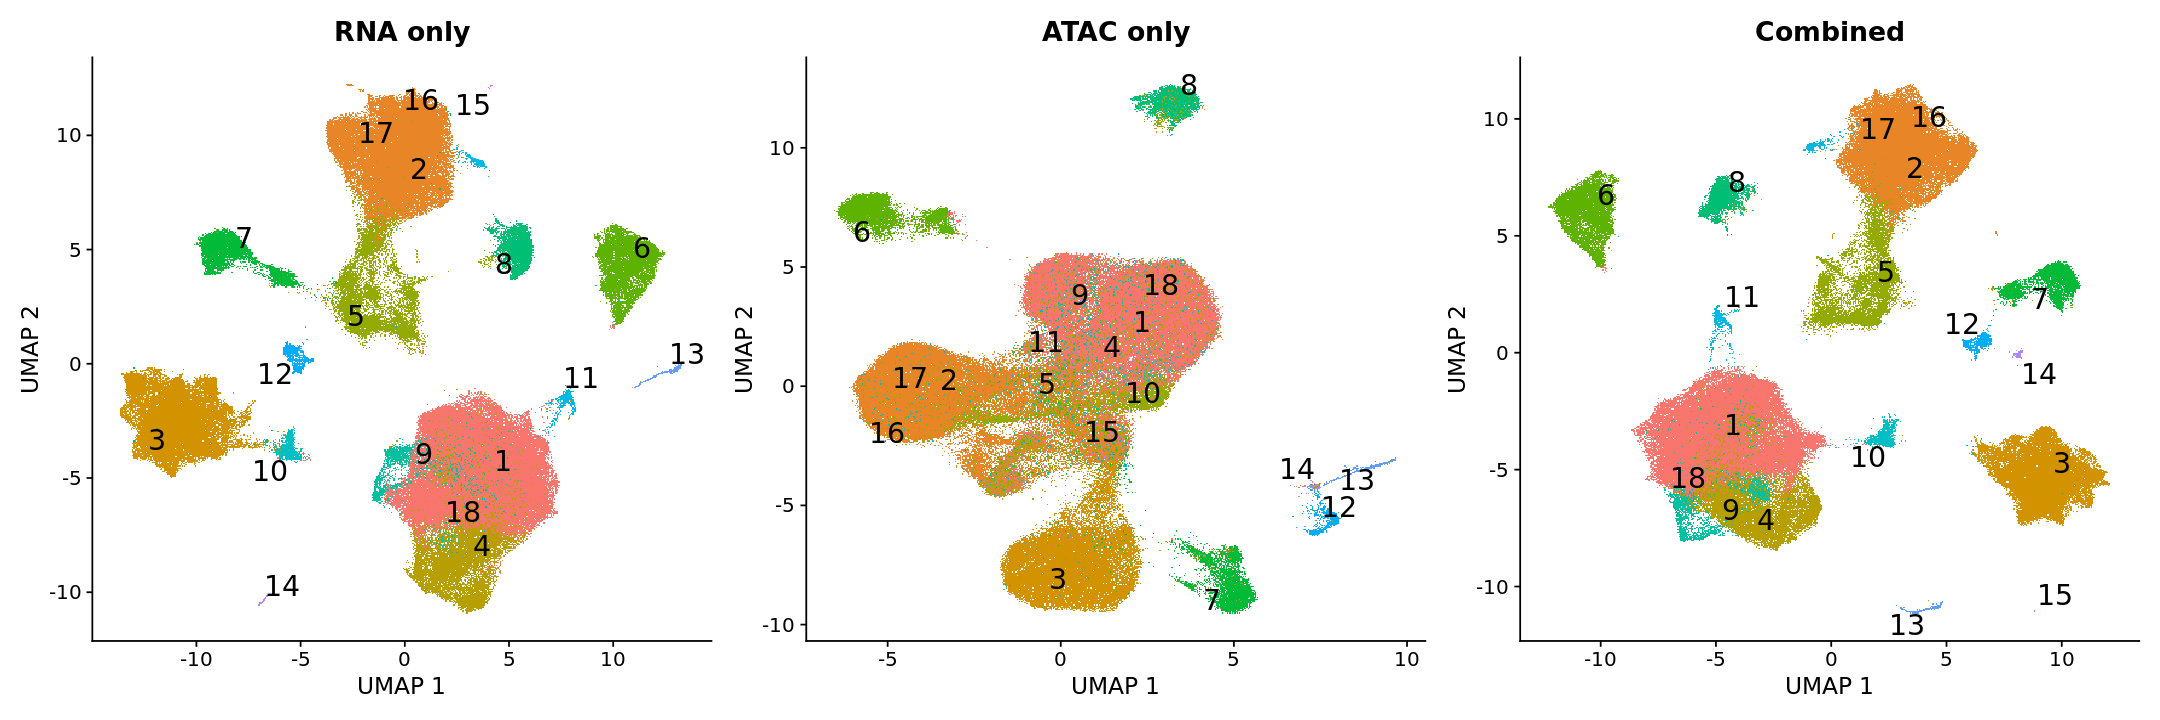

In [30]:
#basic UMAPs colored by cluster
options(repr.plot.width=18, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))